# Poisson HMM Demo
## Applying an HMM to electrophysiology data from a motor-control task

In this notebook, we'll show how SSM can be used for modeling neuroscience data. This notebook is based off the 2008 paper ["Detecting Neural-State Transitions Using Hidden Markov Models for Motor Cortical Prostheses"](https://web.stanford.edu/~shenoy/GroupPublications/KemereEtAlJNeurophysiol2008.pdf) by Caleb Kemere _et al_.  

  
Kemere shows that an HMM can be used to detect neural transitions in a reaching task performed by a monkey. Crucially, by cleverly configuring the HMM states, the authors are also able to decode which target the monkey reached to using their trained HMM. See the paper for more details on the data and experimental set-up.
  
First, we need to load in the data. Though the data is not yet publicly available, we are hoping to make it available soon. We will assume that you have the dependencies included in SSM installed.

In [7]:
from scipy.io import loadmat
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%matplotlib inline

## 1. Background

This dataset contains neural recordings made using a Utah array (96 electrodes) implanted in pre-motor cortex a macaque performing a reach task.
During the task, the monkey must reach to one of 8 targets, as indicated by a cue on a screen.
Each trial consists of 3 phases: a **baseline** phase, a **plan** phase, and a **move** phase.
We describe these phases below:

1. **baseline**: The animal fixates and places his hand in the center of the screen.
2. **plan**: A target appears in one of 8 locations (radially spread out from the center of the screen).
The monkey does not yet begin reaching.
3. **move**: A go-cue comes on, telling the monkey to begin his reach. Upon successfully reaching the target, the monkey receives a liquid reward.

The neural data has been spike-sorted and binned in 10ms intervals.  
  
**Note**: This data contains both single and multi-unit spiking activity. We'll be loose with terminology and use the term "neuron" and "unit" interchangeably here.

## 2. Load the dataset

The dataset is provided in the form of a .mat file, which we can load into Python using `scipy.io.loadmat`.
Once we load the data, `struct` is a dictionary with the following keys:
  
1. `FR`: A numpy array of (neuron, time-bin, trial) with size (190, 155, 1127). The trials have already been time aligned, such that the plan and movement periods begin in the same time-bin for all of the 1127 trials.
2. `base_idx`: Indices of time-bins corresponding to the baseline period (see Section #1).
3. `plan_idx`: Indices of time-bins corresponding to the plan period.
4. `move_idx`: Indices of time-bins corresponding to the movement period.
5. `targets`: Length 8 list of the x,y coordinates for each of the 8 targets.
5. `cInds`: A nested list, where `cInds[0]` is list of all trials to target 1, `cInds[1]` is a list of all trials to target 2, etc.
5. `train_trials`: Indices of the trials we will use for training.
5. `test_trials`: Indices of the trials we will use for testing.
  
  
Below, after we pull out the data, we visualize the spike data for the first trials.
We see that there is a noticeable increase in neural activity when the movement period starts. 

In [2]:
DATA_PATH = "/Users/Bantin/Documents/Linderman-Shenoy/Kemere2008/extracted_data/H1217/H1217_hmm_data.mat"
struct = loadmat(DATA_PATH)

In [3]:
FR = struct['FR']
base_idx = struct['base_idx'][0]
plan_idx = struct['plan_idx'][0]
move_idx = struct['move_idx'][0]
targets = struct['targets']
target_idx = struct['cInds']
train_idx = struct['train_trials']
test_idx = struct['test_trials']

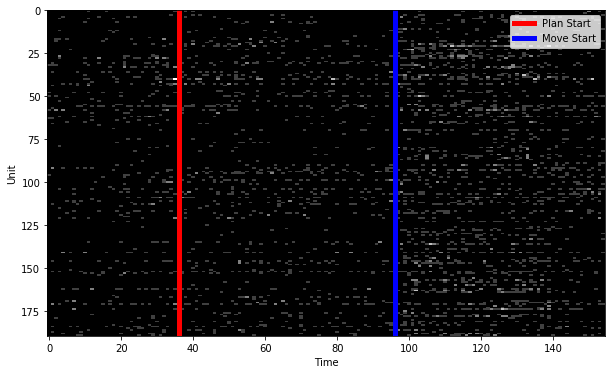

In [4]:
# Display a spike raster of the image
plt.figure(figsize=(10,6))
plt.imshow(FR[:,:,1], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = FR.shape[1]
plan_start = plan_idx[0]
move_start = move_idx[0]

plt.axvline(x=plan_start, color='red', linewidth=5, label='Plan Start')
plt.axvline(x=move_start, color='blue', linewidth=5, label='Move Start')
plt.ylabel("Unit")
plt.xlabel("Time")
plt.legend()
plt.tight_layout
plt.show()

## 3. Fit a simple 3 state HMM
As a first step, we'll fit a simple 3 state HMM to the training data. For this, we're not aiming to actually decode which target the monkey reached to, we're merely going to check if we can uncover the the 3 phases of the reach (baseline, plan, move) in an unsupervised way using an HMM.
  
### 3.1 Format the data for SSM
In order for the following steps to make sense, we need to give more details about how the `FR` array is arranged. As mentioned, it is formatted as (neurons, time, trials). However, not every trial in the dataset is actually the same length -- this is because the length of the delay period is randomized, and it takes the monkey varying amounts of time to reach the target.  

To acount for this, the `FR` array has been padded with NaNs so that all trials have the same length. This is very helpful, because it makes it easy to know which time bins correspond to each phase of the task. 

However, for our purposes, we don't want to include the NaNS when fitting our HMM (in fact, SSM will throw an error if we do). 
Instead, we will reset the NaN entries in `FR` to be zeros. We will then pass a mask which tells SSM to ignore the entries which were previously NaNs. This mask will be `False` where the data is missing (i.e where we had NaNs) and true elsewhere.
In order to use the Poisson observation model, SSM expects the observation data to be Integers. This is done in the cell below.

In [5]:
train_trials = []
train_masks = []
for i, idx in enumerate(train_idx):
    spikes_cur = np.squeeze(FR[:,:,i])
    mask_cur = np.invert(np.isnan(spikes_cur))
    train_masks.append(mask_cur)
    spikes_cur[np.isnan(spikes_cur)] = 0
    spikes_cur = spikes_cur.astype(int)
    train_trials.append(spikes_cur)

### 3.2 Fit a 3-state HMM
The syntax to create a standard HMM object using SSM is:  
`ssm.HMM(K, N, transitions=<transition_class>, observations=<observation_class>)`

Where $K$ is the number of discrete states, and $N$ is the dimensensionality of the observations. We'll use standard transitions and Poisson observations.
To fit our HMM to the training data, we call `HMM.fit(train_trials, masks=train_masks)`